### Overview

Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus.

Most people infected with the COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment.  Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.

The best way to prevent and slow down transmission is be well informed about the COVID-19 virus, the disease it causes and how it spreads. Protect yourself and others from infection by washing your hands or using an alcohol based rub frequently and not touching your face. 

(Source: World Health Organization)

### Covid-19 across the world
The coronavirus COVID-19 is affecting 194 countries and territories around the world.
The trajectory of the disease has been similar in many countries, but Italy has been particularly hard hit with over 6,800 deaths, while Japan and some other east Asian countries have seen a slower spread. However, the fact that some countries test more than others, and with different approaches, means that these statistics may under-represent the true spread of the disease for some places.

In this notebook, I attempt to forecast the spread of the disease.



### Importing the libraries

In [0]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm import tqdm_notebook
from datetime import datetime 
from pandas import Series 
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

In [3]:
# training data
train = pd.read_csv('.../train.csv')
train.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


In [5]:
# testing data 
test = pd.read_csv('.../test.csv')
test.head()

,ForecastId,Province/State,Country/Region,Lat,Long,Date
0,1,NaN,Afghanistan,33.0,65.0,2020-03-12
1,2,NaN,Afghanistan,33.0,65.0,2020-03-13
2,3,NaN,Afghanistan,33.0,65.0,2020-03-14
3,4,NaN,Afghanistan,33.0,65.0,2020-03-15
4,5,NaN,Afghanistan,33.0,65.0,2020-03-16


### Exploratory Data Analysis

In [6]:
# Total number of records 
len(train)

17324

In [7]:
# checking for missing values 
train.isnull().any()

Id                False
Province/State     True
Country/Region    False
Lat               False
Long              False
Date              False
ConfirmedCases    False
Fatalities        False
dtype: bool

We see that the "Province/State" column contains missing values. However, for our work, we will not be focussing on that particular column.

In [0]:
# Create copy of training data 
df_train = train.copy()

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17324 entries, 0 to 17323
Data columns (total 8 columns):
Id                17324 non-null int64
Province/State    7930 non-null object
Country/Region    17324 non-null object
Lat               17324 non-null float64
Long              17324 non-null float64
Date              17324 non-null object
ConfirmedCases    17324 non-null float64
Fatalities        17324 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 1.1+ MB


In [0]:
# Renaming columns for convinience
df_train.rename(columns={'Id':'id', 'Province/State':'state','Country/Region':'country','Lat':'lat', 'Long':'lng', 'Date':'date', 'ConfirmedCases':'confirmed', 'Fatalities':'deaths'}, inplace=True)

In [11]:
df_train.head()

,id,state,country,lat,lng,date,confirmed,deaths
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


Let us first look at how many confirmed cases and deaths have occurred in each country.

In [12]:
# total confirmed cases for each coutry
total_cases = df_train.groupby('country').confirmed.sum()
total_cases

country
Afghanistan             249.0
Albania                 624.0
Algeria                 991.0
Andorra                 423.0
Antigua and Barbuda      10.0
                        ...  
Uruguay                 513.0
Uzbekistan              174.0
Venezuela               322.0
Vietnam                1439.0
Zambia                   11.0
Name: confirmed, Length: 163, dtype: float64

In [13]:
# total deaths across all the countries 
total_deaths = df_train.groupby('country').deaths.sum()
total_deaths

country
Afghanistan             1.0
Albania                17.0
Algeria                77.0
Andorra                 1.0
Antigua and Barbuda     0.0
                       ... 
Uruguay                 0.0
Uzbekistan              0.0
Venezuela               0.0
Vietnam                 0.0
Zambia                  0.0
Name: deaths, Length: 163, dtype: float64

Top 10 countries with the most confirmed cases 

In [14]:
total_cases.nlargest(10)

country
China             3342060.0
Italy              438821.0
Iran               231132.0
Korea, South       172802.0
Spain              157432.0
Germany            136101.0
US                 122478.0
France             102321.0
Switzerland         39168.0
United Kingdom      29609.0
Name: confirmed, dtype: float64

Top 10 countries with the most deaths

In [15]:
total_deaths.nlargest(10)

country
China             114573.0
Italy              33959.0
Iran               13124.0
Spain               7345.0
France              2859.0
US                  1727.0
Korea, South        1439.0
United Kingdom      1100.0
Netherlands          690.0
Japan                412.0
Name: deaths, dtype: float64

Visualizing the confirmed cases and deaths across the most affected countries

Text(0, 0.5, 'Confirmed Cases ')

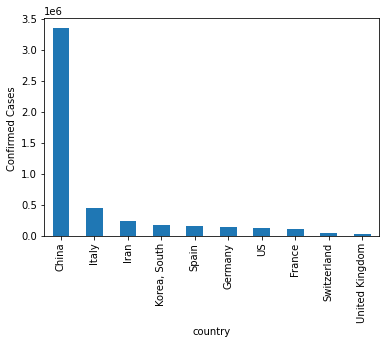

In [16]:
ax = total_cases.nlargest(10).plot.bar()
ax.set_ylabel('Confirmed Cases ')

Text(0, 0.5, 'Deaths')

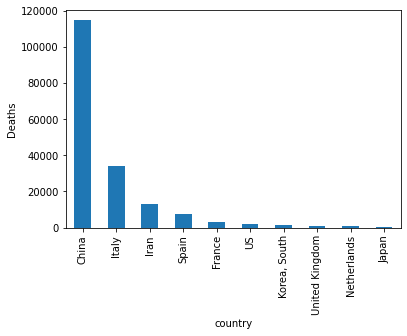

In [17]:
ax = total_deaths.nlargest(10).plot.bar()
ax.set_ylabel('Deaths')

We see that the situation in China, Italy, Iran and Spain is unfortunately severe compared to other countries.

### Country wise analysis

In [0]:
df_group = df_train.groupby('country')

def country_dataframe(country, train):
    train_country = train[train['Country/Region'] == country]
    test_country = test[test['Country/Region'] == country]
    # Make copies
    train_original = train_country.copy()
    test_original = test_country.copy()
    train_country.rename(columns={'Id':'id', 'Province/State':'state','Country/Region':'country','Lat':'lat', 'Long':'lng', 'Date':'date', 'ConfirmedCases':'confirmed', 'Fatalities':'deaths'}, inplace=True)
    test_country.rename(columns={'Id':'id', 'Province/State':'state','Country/Region':'country','Lat':'lat', 'Long':'lng', 'Date':'date', 'ConfirmedCases':'confirmed', 'Fatalities':'deaths'}, inplace=True)
    train_original.rename(columns={'Id':'id', 'Province/State':'state','Country/Region':'country','Lat':'lat', 'Long':'lng', 'Date':'date', 'ConfirmedCases':'confirmed', 'Fatalities':'deaths'}, inplace=True)
    test_original.rename(columns={'Id':'id', 'Province/State':'state','Country/Region':'country','Lat':'lat', 'Long':'lng', 'Date':'date', 'ConfirmedCases':'confirmed', 'Fatalities':'deaths'}, inplace=True)
    
    ### CONVERT TO DATETIME 
    train_country['date'] = pd.to_datetime(train_country.date, format="%Y-%m-%d")
    test_country['date'] = pd.to_datetime(test_country.date, format='%Y-%m-%d')
    train_original['date'] = pd.to_datetime(train_original.date, format='%Y-%m-%d')
    test_original['date'] = pd.to_datetime(test_original.date, format='%Y-%m-%d')

    ### FEATURE EXTRACTION 
    for i in (train_country, test_country, train_original, test_original):
        i['year'] = i.date.dt.year
        i['month'] = i.date.dt.month
        i['day'] = i.date.dt.day
    
    # indexing the date column to get the time period on the x axis
    train_country.index = train_country['date']
        
    return train_country, test_country, train_original, test_original

### VISUALIZING THE CONFIRMED CASES AND DEATHS COUNTRY-WISE OVER TIME 

In [0]:
def visualize_confirmed_cases(country, train):
    """ plot showing growth of number of confirmed cases for country """
    train_country, test_country, train_original, test_original = country_dataframe(country, train)
    confirmed = train_country['confirmed']
    deaths = train_country['deaths']
    
    train_country['month'] = train_country['date'].dt.month_name()
    
    plt.figure(figsize=(16,8))
    plt.plot(confirmed, label='confirmed cases')
    plt.title('Confirmed cases from 2020-01-22 to 2020-03-22 ')
    plt.xlabel('Time(year-month)')
    plt.ylabel('confirmed cases')
    plt.legend(loc='best')
    plt.show()
    

In [0]:
def visualize_death_rate(country, train):
    """ plot showing growth of number of deaths for country """
    train_country, test_country, train_original, test_original = country_dataframe(country, train)
    confirmed = train_country['confirmed']
    deaths = train_country['deaths']
    
    train_country['month'] = train_country['date'].dt.month_name()
    
    plt.figure(figsize=(16,8))
    plt.plot(deaths, label='Deaths')
    plt.title('Deaths from 2020-01-22 to 2020-03-22 ')
    plt.xlabel('Time(year-month)')
    plt.ylabel('Deaths')
    plt.legend(loc='best')
    plt.show()
    
    

## CHINA

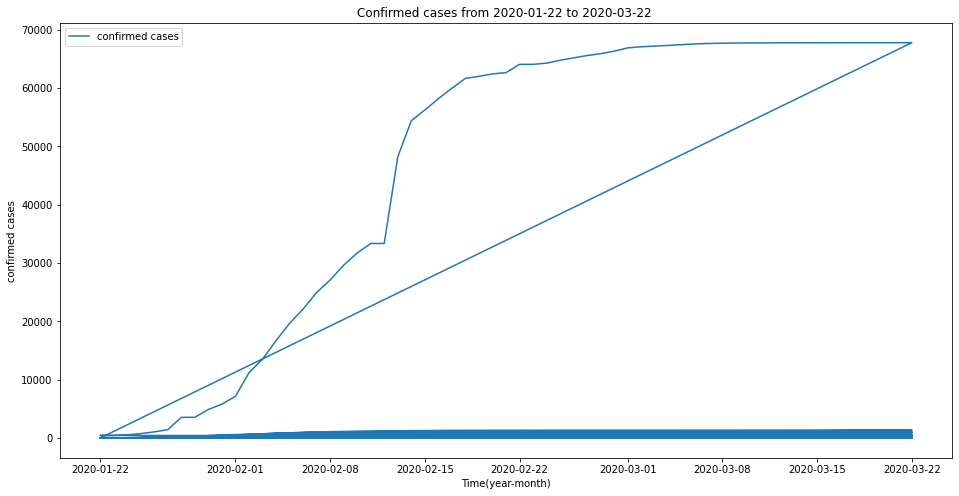

In [21]:
visualize_confirmed_cases('China', train)

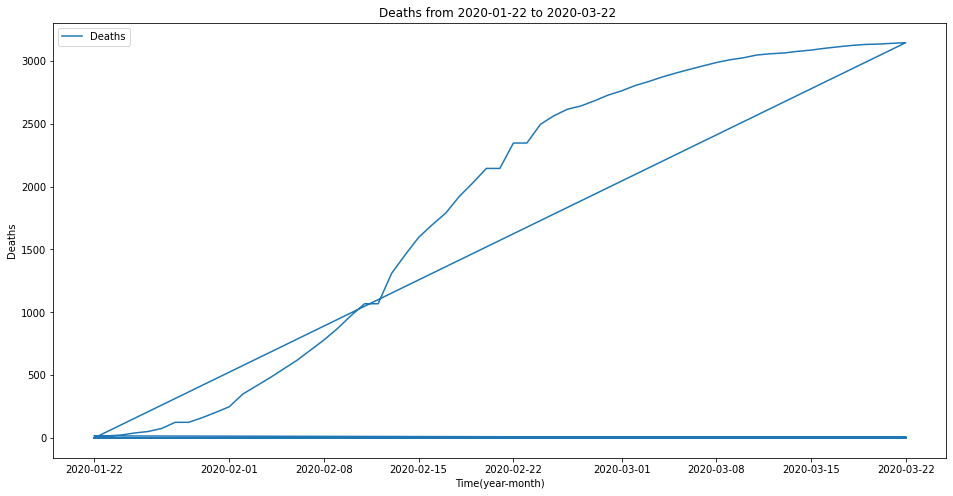

In [22]:
visualize_death_rate('China', train)

## ITALY

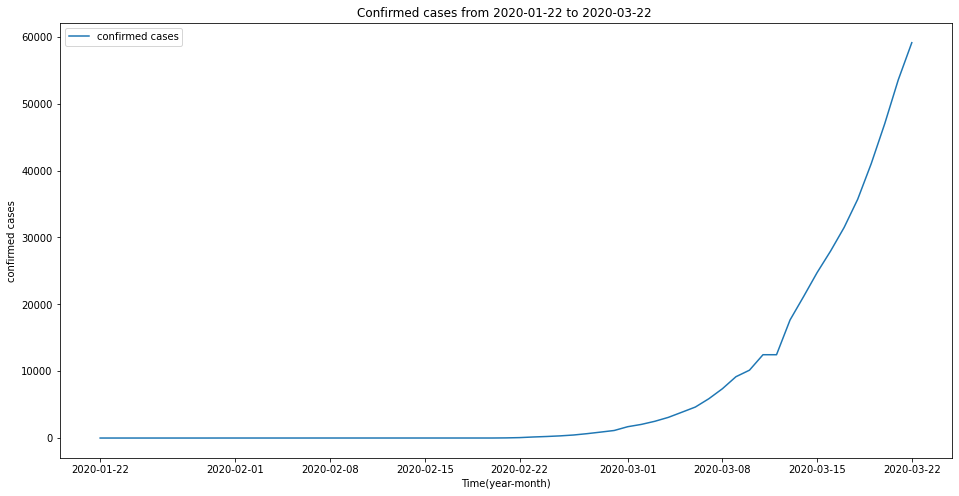

In [23]:
visualize_confirmed_cases('Italy', train)

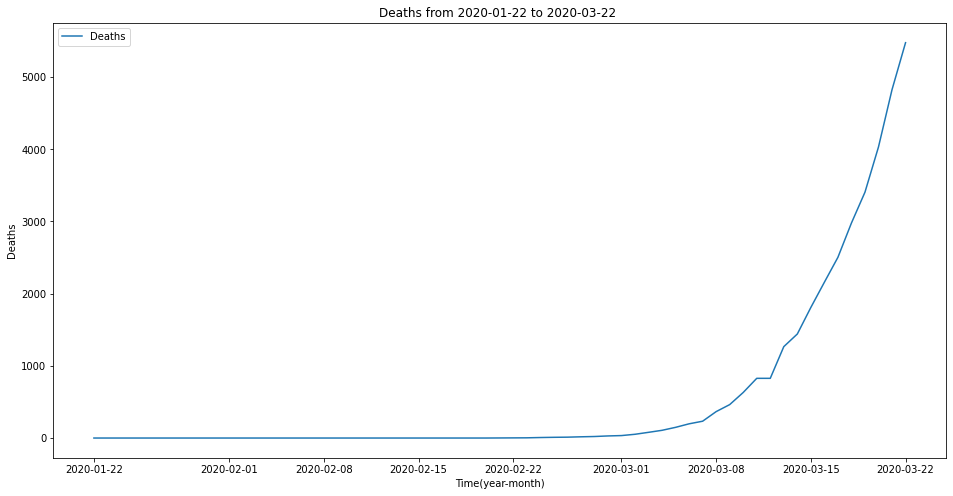

In [24]:
visualize_death_rate('Italy', train)

## IRAN

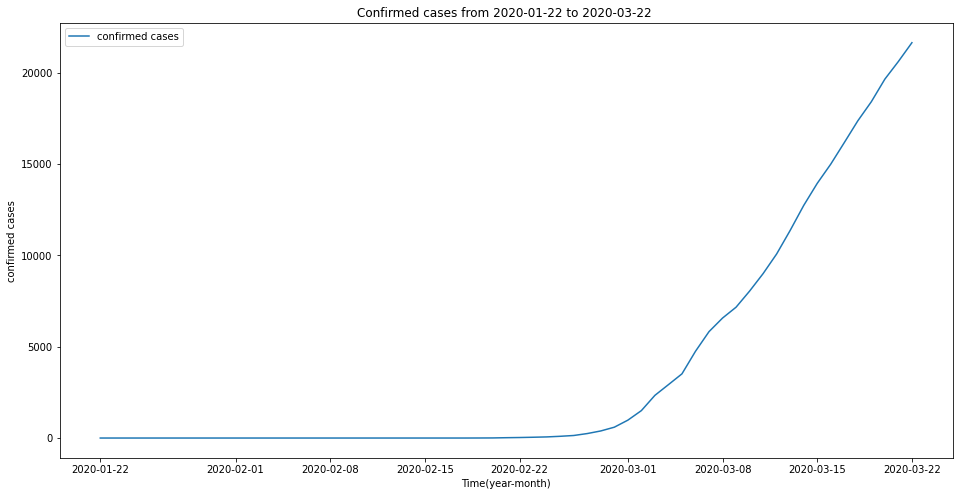

In [25]:
visualize_confirmed_cases('Iran', train)

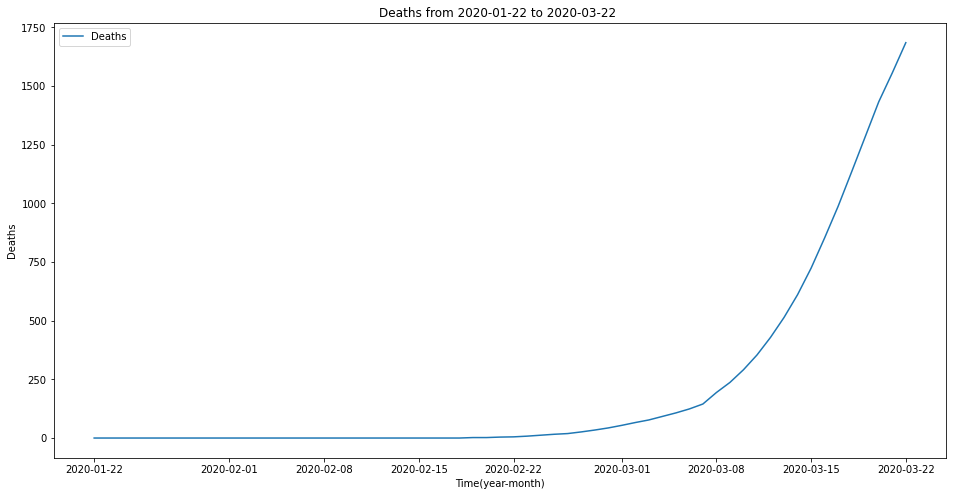

In [26]:
visualize_death_rate('Iran', train)

### BOX PLOTS


In [0]:
def box_plot(country, train):
    train_country, test_country, train_original, test_original = country_dataframe(country, train)
    confirmed = train_country['confirmed']
    deaths = train_country['deaths']
    
    train_country['month'] = train_country['date'].dt.month_name()

    train_country.groupby('month')['confirmed', 'deaths'].sum().plot.bar()

### CHINA

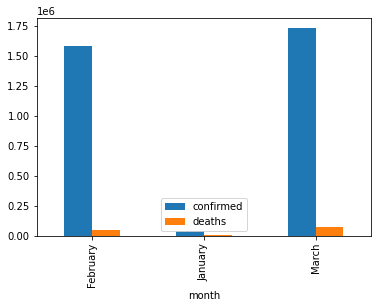

In [28]:
box_plot('China', train)

### ITALY

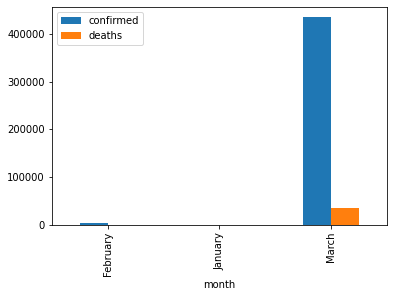

In [29]:
box_plot('Italy', train)

### IRAN

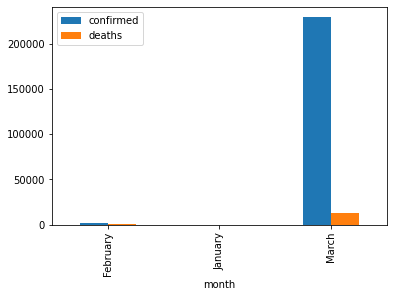

In [30]:
box_plot('Iran', train)

### TIME SERIES FORECASTING

We will attempt to forecast the number of confirmed cases and deaths for each country

In [0]:
def train_test_split(country, train):
    train_country, test_country, train_original, test_original = country_dataframe(country, train)
    train_country.Timestamp = pd.to_datetime(train_country.date, format='%d-%m-%Y')
    train_country.index = train_country.Timestamp
    daily = train_country.resample('d').sum()
    test_country['Timestamp'] = pd.to_datetime(test_country.date, format='%d-%m-%Y')
    test_country.index = test_country.Timestamp
    test_country = test_country.resample('d').sum()
    
    ## SPLITTING THE DATA INTO TRAINING AND VALIDATION SETS
    
    Train = train_country.ix['2020-02-17':'2020-03-17']
    valid = train_country.ix['2020-03-17':'2020-03-22']

    
    return Train, valid

### SIMPLE EXPONENTIAL SMOOTHING

- In this technique, we assign larger weights to more recent observations than to observations in the past.
- The weights decrease exponentially as the observations come from the past, the smallest weights are associated with the oldest observations. 

**NOTE** : If we give the entire weight to the latest observation, this method would be very similar to the naive approach. So, we can say that the naive approach is a type of simple exponential smoothing where the entire weight is given to the latest observation.

Here, the predictions are made by assigning larger weights to the recent values and lesser weights to the old values.

In [0]:

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
from math import sqrt 

def ses_confirmed_cases(country, train):
    Train, valid = train_test_split(country, train)
    y_hat_avg = valid.copy()
    fit1 = SimpleExpSmoothing(np.asarray(Train['confirmed'])).fit(smoothing_level=0.6, optimized=False)
    y_hat_avg['SES'] = fit1.forecast(len(valid))
    plt.figure(figsize=(15,8))
    plt.plot(Train['confirmed'], label='Train')
    plt.plot(valid['confirmed'], label='Valid')
    plt.plot(y_hat_avg['SES'], label='SES')
    plt.title('Confirmed Cases forecast using Simple Exponential Smoothing')
    plt.legend(loc='best')
    plt.show()

def ses_deaths(country, train):
    Train, valid = train_test_split(country, train)
    y_hat_avg = valid.copy()
    fit1 = SimpleExpSmoothing(np.asarray(Train['deaths'])).fit(smoothing_level=0.6, optimized=False)
    y_hat_avg['SES'] = fit1.forecast(len(valid))
    plt.figure(figsize=(15,8))
    plt.plot(Train['deaths'], label='Train')
    plt.plot(valid['deaths'], label='Valid')
    plt.plot(y_hat_avg['SES'], label='SES')
    plt.title('Number of deaths forecast using Simple Exponential Smoothing')
    plt.legend(loc='best')
    plt.show()

### ITALY

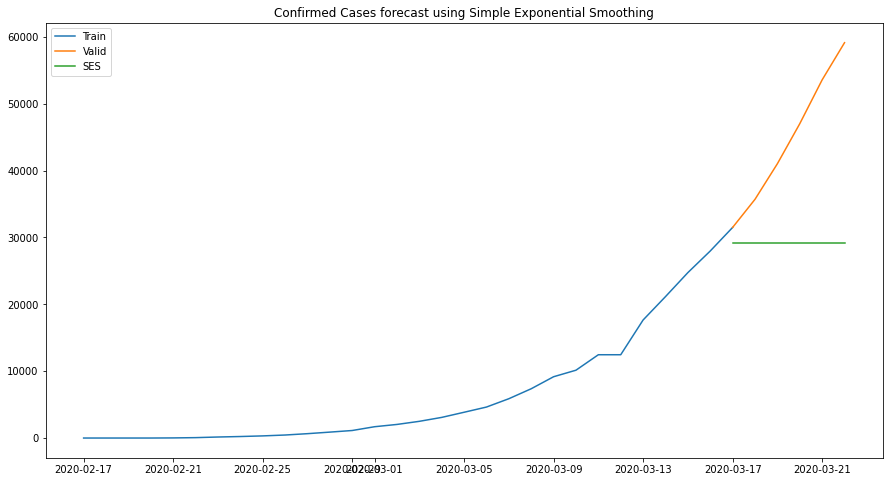

In [33]:
ses_confirmed_cases('Italy', train)

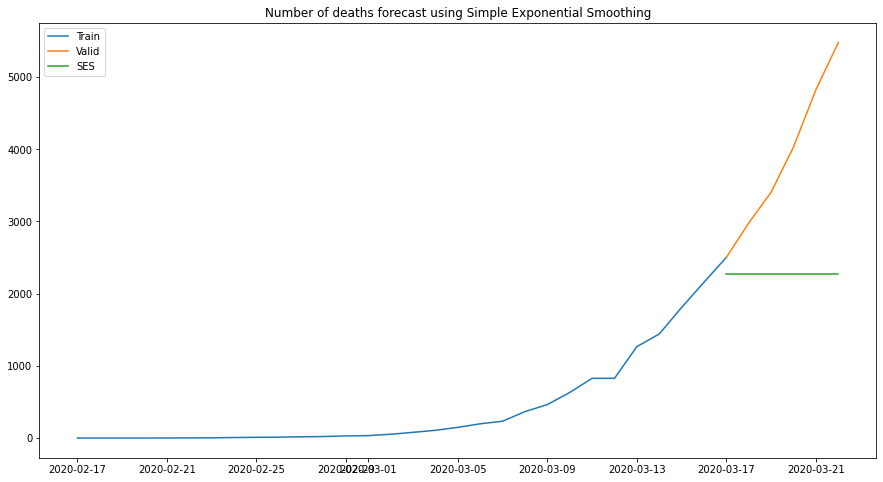

In [34]:
ses_deaths('Italy', train)

### IRAN

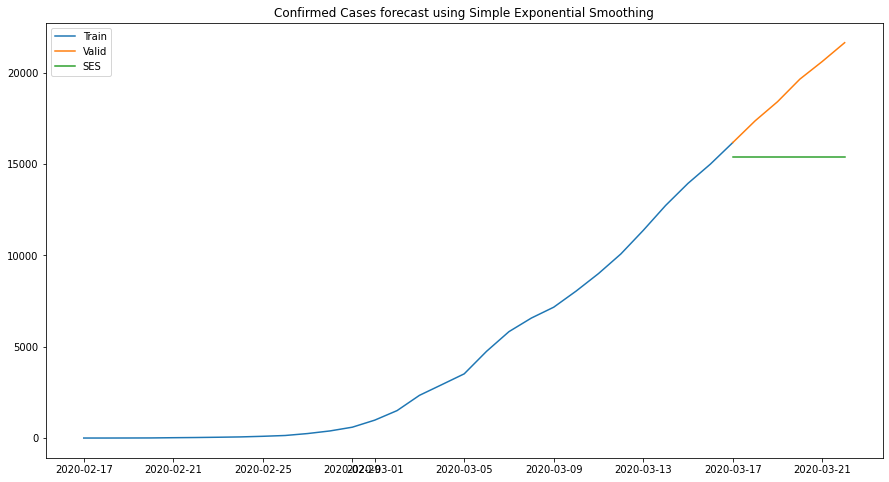

In [35]:
ses_confirmed_cases('Iran', train)

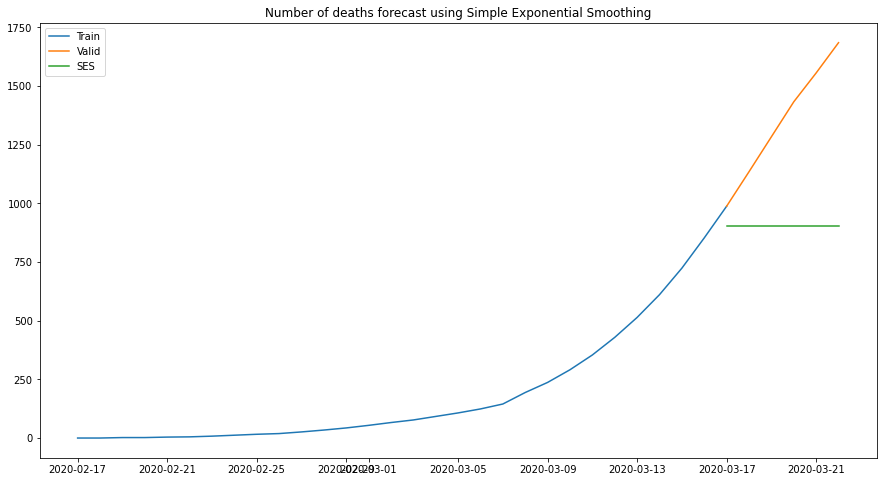

In [36]:
ses_deaths('Iran', train)

### Holt's linear trend model
This method is an extention of the simple exponential smoothing method but takes into account the trend of the dataset. The forecast in this method is a function of the level and the trend.

First, let us visualize the trend, seasonality and error in the series. 

The time series can be decomposed into 4 parts : 
  - Observed, which is the original time series 
  - Trend i.e the increasing or decreasing behaviour of the time series 
  - Seasonal
  - Residual , which is obtained by removing any seasonality or trend in the time series 
  

In [0]:
def holts_confirmed_cases(country, train):
    Train, valid = train_test_split(country, train)
    y_hat_avg = valid.copy()
    fit1 = Holt(np.asarray(Train['confirmed'])).fit(smoothing_level=0.3, smoothing_slope=0.1)
    y_hat_avg['Holt_linear'] = fit1.forecast(len(valid))
    plt.figure(figsize=(16,8))
    plt.plot(Train['confirmed'], label = 'Train')
    plt.plot(valid['confirmed'], label = 'Valid')
    plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
    plt.title("Confirmed Cases forecast using Holt's Linear Model")
    plt.legend(loc='best')
    plt.show()
    
def holts_deaths(country, train):
    Train, valid = train_test_split(country, train)
    y_hat_avg = valid.copy()
    fit1 = Holt(np.asarray(Train['deaths'])).fit(smoothing_level=0.3, smoothing_slope=0.1)
    y_hat_avg['Holt_linear'] = fit1.forecast(len(valid))
    plt.figure(figsize=(16,8))
    plt.plot(Train['deaths'], label = 'Train')
    plt.plot(valid['deaths'], label = 'Valid')
    plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
    plt.title("Number of deaths forecast using Holt's Linear Model")
    plt.legend(loc='best')
    plt.show()

### ITALY

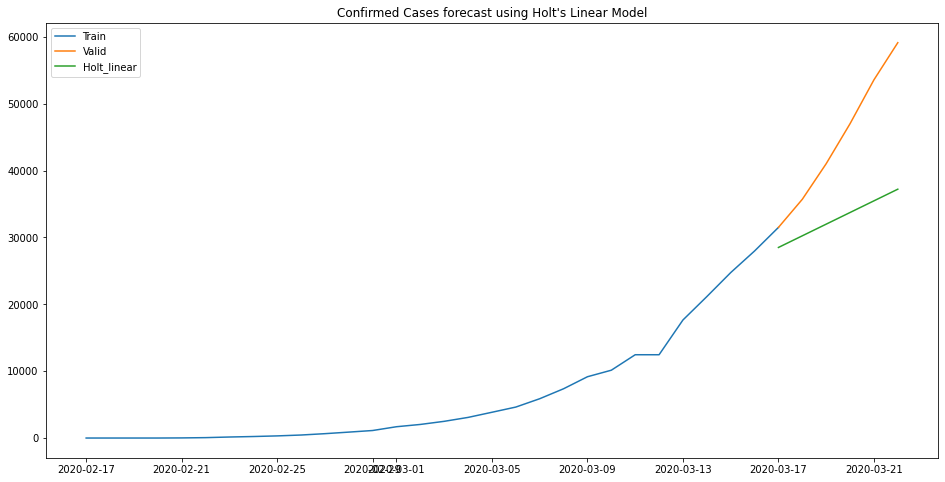

In [38]:
holts_confirmed_cases('Italy', train)

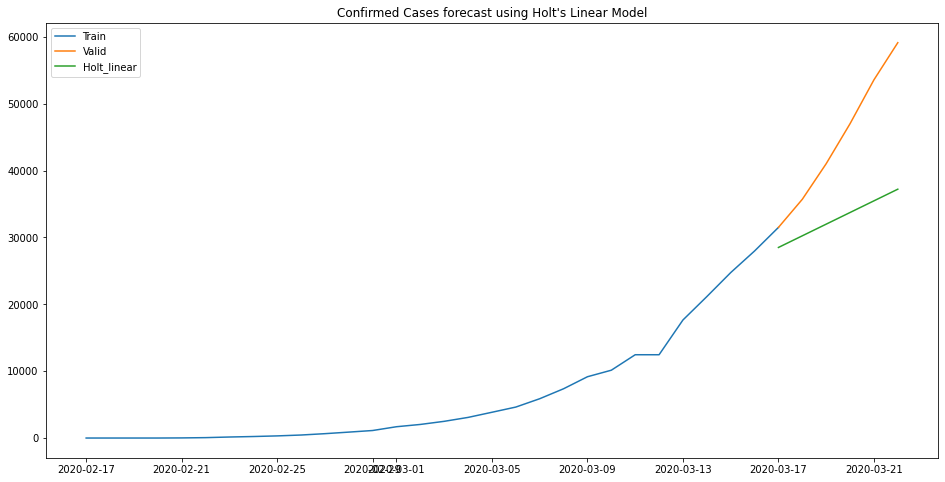

In [39]:
holts_confirmed_cases('Italy', train)

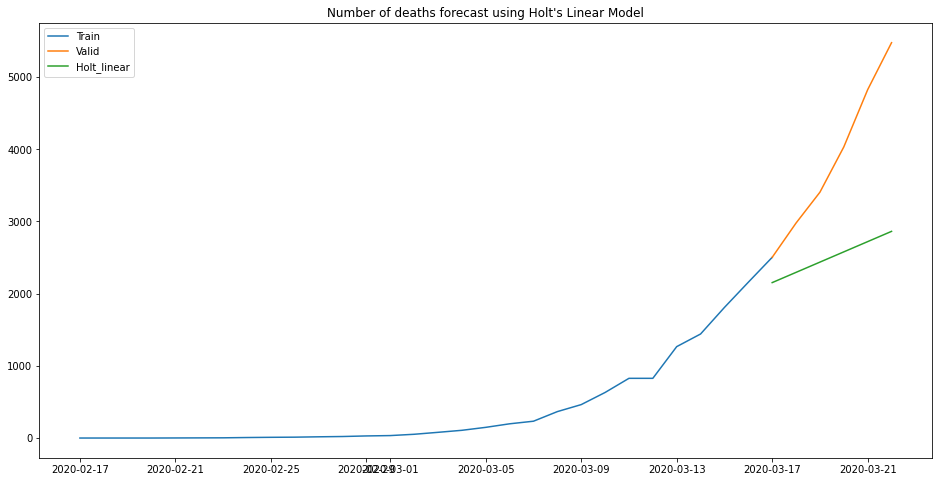

In [40]:
holts_deaths('Italy', train)

### IRAN

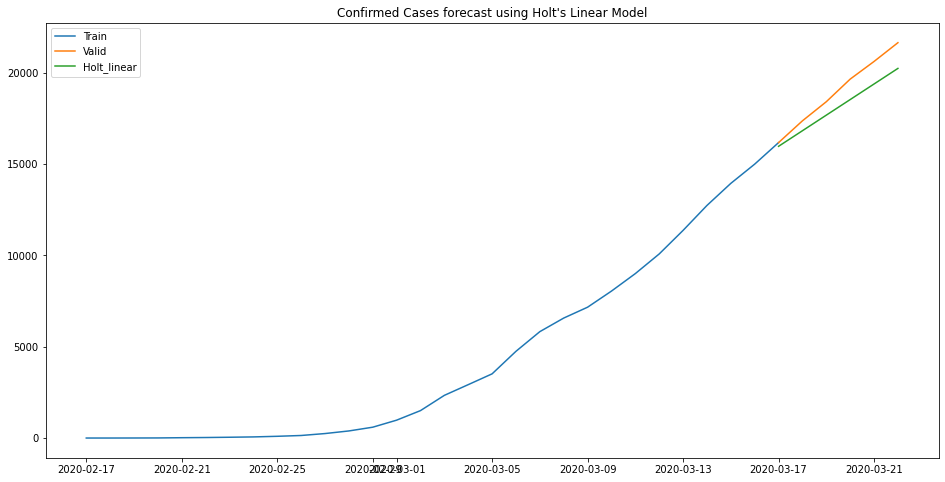

In [41]:
holts_confirmed_cases('Iran', train)

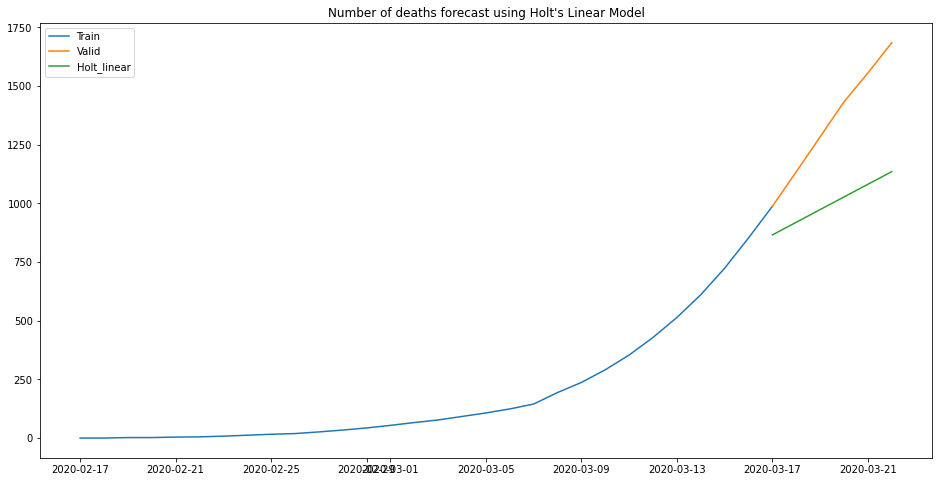

In [42]:
holts_deaths('Iran', train)

### Forecast for Italy

In [0]:
train_italy, test_italy, train_original, test_original = country_dataframe('Italy', train)

In [45]:
test_italy.head()

,ForecastId,state,country,lat,lng,date,year,month,day
5719,5720,NaN,Italy,43.0,12.0,2020-03-12,2020,3,12
5720,5721,NaN,Italy,43.0,12.0,2020-03-13,2020,3,13
5721,5722,NaN,Italy,43.0,12.0,2020-03-14,2020,3,14
5722,5723,NaN,Italy,43.0,12.0,2020-03-15,2020,3,15
5723,5724,NaN,Italy,43.0,12.0,2020-03-16,2020,3,16


In [0]:
Train, valid = train_test_split('Italy', train)

# Confirmed cases
fit1 = Holt(np.asarray(Train['confirmed'])).fit(smoothing_level=0.3, smoothing_slope=0.1)
predict_cases = fit1.forecast(len(test_italy))
test_italy['predict_cases'] = predict_cases

# Deaths
fit2 = Holt(np.asarray(Train['deaths'])).fit(smoothing_level=0.3, smoothing_slope=0.1)
predict_deaths = fit2.forecast(len(test_italy))
test_italy['predict_deaths'] = predict_deaths

In [47]:
test_italy

,ForecastId,state,country,lat,lng,date,year,month,day,predict_cases,predict_deaths
5719,5720,NaN,Italy,43.0,12.0,2020-03-12,2020,3,12,28508.495808,2152.787426
5720,5721,NaN,Italy,43.0,12.0,2020-03-13,2020,3,13,30251.512639,2294.748158
5721,5722,NaN,Italy,43.0,12.0,2020-03-14,2020,3,14,31994.529470,2436.708890
5722,5723,NaN,Italy,43.0,12.0,2020-03-15,2020,3,15,33737.546300,2578.669622
5723,5724,NaN,Italy,43.0,12.0,2020-03-16,2020,3,16,35480.563131,2720.630353
5724,5725,NaN,Italy,43.0,12.0,2020-03-17,2020,3,17,37223.579962,2862.591085
5725,5726,NaN,Italy,43.0,12.0,2020-03-18,2020,3,18,38966.596793,3004.551817
5726,5727,NaN,Italy,43.0,12.0,2020-03-19,2020,3,19,40709.613624,3146.512549
5727,5728,NaN,Italy,43.0,12.0,2020-03-20,2020,3,20,42452.630455,3288.473281
5728,5729,NaN,Italy,43.0,12.0,2020-03-21,2020,3,21,44195.647286,3430.434013


In [0]:
test_italy = test_italy.drop(['state', 'country','lat', 'lng', 'year', 'month', 'day', 'date'], axis=1)

In [49]:
test_italy = test_italy.rename(columns={'predict_cases':'ConfirmedCases', 'predict_deaths':'Fatalities'})
test_italy.head()

,ForecastId,ConfirmedCases,Fatalities
5719,5720,28508.495808,2152.787426
5720,5721,30251.512639,2294.748158
5721,5722,31994.529470,2436.708890
5722,5723,33737.546300,2578.669622
5723,5724,35480.563131,2720.630353


### Forecast for Iran

In [50]:
train_iran, test_iran, train_original, test_original = country_dataframe('Iran', train)
Train, valid = train_test_split('Iran', train)


# Confirmed cases
fit1 = Holt(np.asarray(Train['confirmed'])).fit(smoothing_level=0.3, smoothing_slope=0.1)
predict_cases = fit1.forecast(len(test_iran))
test_iran['predict_cases'] = predict_cases

# Deaths
fit2 = Holt(np.asarray(Train['deaths'])).fit(smoothing_level=0.3, smoothing_slope=0.1)
predict_deaths = fit2.forecast(len(test_iran))
test_iran['predict_deaths'] = predict_deaths

test_iran = test_iran.drop(['state', 'country','lat', 'lng', 'year', 'month', 'day', 'date'], axis=1)

test_iran = test_iran.rename(columns={'predict_cases':'ConfirmedCases', 'predict_deaths':'Fatalities'})
test_iran.head()

,ForecastId,ConfirmedCases,Fatalities
5547,5548,15966.352022,865.847547
5548,5549,16819.152289,919.785628
5549,5550,17671.952557,973.723708
5550,5551,18524.752825,1027.661789
5551,5552,19377.553093,1081.599870
